# Mineral Trends & Mining Exploration Using Adjacency Lists

`---------------------------`

With **Mr Fugu Data Science**


# (◕‿◕✿)


[Github](https://github.com/MrFuguDataScience) | [YouTube](https://www.youtube.com/channel/UCbni-TDI-Ub8VlGaP8HLTNw)

# Core concepts:

+ Webscraping
+ Graphing with Bokeh
+ Regex
+ Adjacency List 
+ GeoJSON file format creation
+ Evaluate Top 20 Minerals, Compare 2 Minerals and check for similarity

# This is a project where you can take a List of Data and use  Graph Theory Concept: Adjacency Lists.

+ I chose this because I remember from Physical Geoology in College, that certain Minerals will develop together. This is a trait used while looking for Pegmatites, Ore Mining and Recovery as well as Exporation work. 

In [1]:
# Dependencies that may need to be installed: 
#-----------------------

# !pip install shapely
# !pip install pdf2image
# !pip install Bokeh

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn
import re
import requests
from bs4 import BeautifulSoup as bsopa
from shapely import geometry
from bokeh.io import show,output_notebook,output_file
# from bokeh.models import ColumnDataSource,PanTool, ResetTool
from bokeh.plotting import figure
# from bokeh.io import show, output_notebook, output_file
from bokeh.models import (
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper,
    LogColorMapper,
    Plot,
    ColumnDataSource,
    PanTool,
    ResetTool
)
# from bokeh.plotting import figure
from bokeh.palettes import Spectral11 as palette 
import collections
from collections import defaultdict

from PIL import Image
from pdf2image import convert_from_path

# USGS Mining Data:

In [3]:
# -________Data_________- (Citation linked to dataset)

mineral_deps=pd.read_csv('mrds.csv',low_memory=False,index_col=False) # consider chunking then do a loop 
mineral_dep=mineral_deps.iloc[:,[1,4,5,6,8,9,11,12,13,14,19,23]] #,24,32,33]]


In [4]:
mineral_dep.head()

url            site_name  \
0  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     Lookout Prospect   
1  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  Lucky Find Prospect   
2  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  Mccullough Prospect   
3  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...      Lucky Jim Claim   
4  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   Matilda Occurrence   

   latitude  longitude        country   state com_type commod1       commod2  \
0  55.05612 -132.14344  United States  Alaska        M  Copper  Gold, Silver   
1  55.52751 -132.68514  United States  Alaska        M  Copper          Gold   
2  55.97751 -132.99906  United States  Alaska        M  Copper           NaN   
3  55.52195 -132.68653  United States  Alaska        M    Gold           NaN   
4  55.14556 -132.05233  United States  Alaska        M    Gold           NaN   

        commod3                               ore    work_type  
0           NaN   Chalcopyrite, Covellite, Pyrite          NaN  
1           NaN              Chalcopyrite, Pyrite  Underground  
2    Zinc, Gold  Chalcopyrite, Pyrite, Sphalerite          NaN  
3  Copper, Lead         Galena, Malachite, Pyrite          NaN  
4           NaN                            Pyrite          NaN

In [5]:
output_notebook() # inline graphs/plots

Loading BokehJS ...

In [6]:
"""
Finding Unique Minerals and appending to a list:
1.) take (Na) values and fill them with empty string, then split on comma and use (apply)
function with list comprehension to strip.

2.) iterate and convert to a set, getting rid of duplicates

3.) Iterate the set and create a unique list and append a value that doesn't already exists

4.) return unique list

** The mineral_dep.comm1,2,3: correspond to the Most-least occuring mineral in a series
Such as Primary Mineral, Secondary etc...
"""

def unique_minerals_(list1): 
    array=np.array(list1.fillna('').str.split(',').apply(lambda x: [i.strip() for i in x]))
    q=set(x for l in array for x in l)
    unique_list = []       
    for x in q: 
#         # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

#-------------------------------

mineral_commod01=unique_minerals_(mineral_dep.commod1)
mineral_commod02=unique_minerals_(mineral_dep.commod2)
mineral_commod03=unique_minerals_(mineral_dep.commod3)

mineral_commod=set(mineral_commod01+mineral_commod02+mineral_commod03+['NaN'])
# mineral_commod

# Creating Comprehensive list of Minerals, Ores, Elements:
* Using multiple files as well as *webscraping*

In [7]:
#-------------------- Mineral_name_list-----------
rege=re.compile(r'[a-zA-Z_()]+')
mineral_list=pd.read_table('Mineral_name_list',index_col=False,header=None)
e=[]
mineral_list=mineral_list.apply(lambda x: x.astype(str).str.lower())
mineral_name_parse=re.sub(r'\([^)]*\)+', '',str(mineral_list))
p=mineral_name_parse.split()
y=' '.join(p)
ui=re.compile(r'([^\d])')
bb=ui.findall(y)

final_mineral_names=''.join(bb)

final_mineral_names=final_mineral_names.split()


#---------- Web-scrape another dataset for just minerals and append to other list----
rsp = requests.get('https://www.minerals.net/Varieties-OtherNames/all.aspx')
rsp.status_code
soupify = bsopa(rsp.text, 'lxml')
f=soupify.get_text()[6391:24731] #hack to get specific lines from text
f=f.replace('\n\n\n\n\xa0',' ')
minerals_new_file=f.split()

#--------- Needed another list which has things not shown in final_mineral_names:

mineral_metal_list=pd.read_table('mineral_metal_list.txt',index_col=False,header=None)
mineral_metal=mineral_metal_list.apply(lambda x: x.astype(str).str.lower())
mineral_metal.columns=['names']
mineral_metal=list(mineral_metal.names.unique())

#-------------------- Combining minerals with metals and final_mineral_names:---------

combined_mineral_metals=[*mineral_metal,*final_mineral_names]
combined_mineral_metals=sorted(combined_mineral_metals)
full_mineral_junk=[*combined_mineral_metals,*minerals_new_file]
full_mineral=sorted(set(full_mineral_junk))

#------------------------------- Periodic table of Elements---------

periodic=requests.get('https://www.sigmaaldrich.com/technical-documents/articles/biology/periodic-table-of-elements-names.html')
periodic.status_code
sopify = bsopa(periodic.text, 'lxml')
ff=sopify.get_text()[6582:8319] # specific lines we needed, hack to save time
ff=ff.replace('\n',' ')

c=re.compile(r'([^\d])')
list_periodic_table=c.findall(ff)
joined_perioc_tbl=''.join(list_periodic_table)
cc=joined_perioc_tbl.split()
Periodic_table=sorted(set([*cc,*full_mineral]))

#-------------------- Master list of Minerals,Metals and Gems
d=[]
def fcn_min_met_gem_list(x,y):
    for i in x:
        sub="".join(i)
        s=" ".join(s for s in y if sub.lower() in s.lower())
        d.append(s)
    return d

z=fcn_min_met_gem_list(Periodic_table,mineral_commod)


In [8]:
mineral_name_parse 

'                                                     0\n0                           acanthite \n1    actinolite \n3                      aegirine \n4    aeschynite \n675  zinnwaldite \n678      zoisite \n\n[679 rows x 1 columns]'

In [9]:
"""
Input (z), has a lot of empty strings in the list, so it is being split in empty space.
* Then we are creating a List, and if an item is not in the list append it. 

* List (c) is added to (f) and converted to a sorted, set removing duplicates 
and stored as (ql).

* then iterate one last time and comparing the list mineral_comm01 to (ql)

"""

def list_consolidated_minerals(z,mineral_commod):
    q=' '.join(z)

    x=[]
    for i in q.split(' '):
        if i not in x:
            x.append(i)
    c=x
    f=['Yttrium','Tin','Pyrite','Tripoli','Manganese','Iron','Ball Clay',
       'Fullers Earth','Sulfuric Acid','Sodium', 'Sodium Sulfate',
       'High Calcium', 'Petroleum (Oil)',
       'Rock Asphalt','Semiprecious Gemstone',
      'Pig Iron','Oil Shale','Oil Sands','NaN']
    
    master_comparison_list=c+f
    ql=(set(sorted(master_comparison_list)))

    v=[]
    for i in ql: 
        if i in mineral_commod:
            v.append(i)
    return v

# -----------------------------------

Minerals_consolidated_list=sorted(list_consolidated_minerals(z,mineral_commod01))
# Minerals_consolidated_list

In [10]:
# Minerals_consolidated_list

In [11]:
# Simple function: take NA fill with empty space, iterate and split by (,)

mineral_dep=mineral_dep.fillna('')
v=Minerals_consolidated_list
for g in v:
    array=mineral_dep.commod1.map(lambda x: g in x.split(','))
    mineral_dep[g]=array # this is creating extra columns with True/False if mineral occured

    
mineral_dep[:5]
# mineral_dep

url            site_name  \
0  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...     Lookout Prospect   
1  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  Lucky Find Prospect   
2  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...  Mccullough Prospect   
3  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...      Lucky Jim Claim   
4  https://mrdata.usgs.gov/mrds/show-mrds.php?dep...   Matilda Occurrence   

  latitude longitude        country   state com_type commod1       commod2  \
0  55.0561  -132.143  United States  Alaska        M  Copper  Gold, Silver   
1  55.5275  -132.685  United States  Alaska        M  Copper          Gold   
2  55.9775  -132.999  United States  Alaska        M  Copper                 
3  55.5219  -132.687  United States  Alaska        M    Gold                 
4  55.1456  -132.052  United States  Alaska        M    Gold                 

        commod3  ... Tripoli Tungsten  Uranium  Vanadium  Vermiculite  Water  \
0                ...   False    False    False     False        False  False   
1                ...   False    False    False     False        False  False   
2    Zinc, Gold  ...   False    False    False     False        False  False   
3  Copper, Lead  ...   False    False    False     False        False  False   
4                ...   False    False    False     False        False  False   

   Wollastonite  Zeolites   Zinc  Zirconium  
0         False     False  False      False  
1         False     False  False      False  
2         False     False  False      False  
3         False     False  False      False  
4         False     False  False      False  

[5 rows x 168 columns]

In [12]:
mineral_dep['Uranium'].value_counts() 
# mineral_dep[mineral_dep['Uranium']]=='True'

# len(mineral_dep)

False    294265
True      10367
Name: Uranium, dtype: int64

# `Creating a GeoJson Object` from a `Dataframe`: 
+ Citation below on code formatting; Great Help!

In [13]:
df=mineral_dep

def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection','features':[]}
    
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#-------------------------
cols = ['site_name','state','commod1','country','latitude','longitude']

geojson_minerals = df_to_geojson(df, cols)
# geojson_minerals

In [14]:
geojson_minerals['features']

[{'type': 'Feature',
  'properties': {'site_name': 'Lookout Prospect',
   'state': 'Alaska',
   'commod1': 'Copper',
   'country': 'United States',
   'latitude': 55.05611999999999,
   'longitude': -132.14344},
  'geometry': {'type': 'Point',
   'coordinates': [-132.14344, 55.05611999999999]}},
 {'type': 'Feature',
  'properties': {'site_name': 'Lucky Find Prospect',
   'state': 'Alaska',
   'commod1': 'Copper',
   'country': 'United States',
   'latitude': 55.52751,
   'longitude': -132.68514},
  'geometry': {'type': 'Point', 'coordinates': [-132.68514, 55.52751]}},
 {'type': 'Feature',
  'properties': {'site_name': 'Mccullough Prospect',
   'state': 'Alaska',
   'commod1': 'Copper',
   'country': 'United States',
   'latitude': 55.977509999999995,
   'longitude': -132.99906000000001},
  'geometry': {'type': 'Point',
   'coordinates': [-132.99906000000001, 55.977509999999995]}},
 {'type': 'Feature',
  'properties': {'site_name': 'Lucky Jim Claim',
   'state': 'Alaska',
   'commod1': '

# Choose Mineral of interest:
* Arbitarily choose a mineral, to create a geographic plot of mining locations. 
* The formatting will be a GeoJSON dictionary

In [15]:
uranium=mineral_dep.loc[mineral_dep['Uranium'] == True]
df_=uranium
Uranium_geojson=df_to_geojson(df_, cols)
# Uranium_geojson.dtype


In [16]:
Uranium_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'site_name': 'Cone Mountain',
    'state': 'Alaska',
    'commod1': 'Uranium',
    'country': 'United States',
    'latitude': 56.51365,
    'longitude': -131.73488999999998},
   'geometry': {'type': 'Point',
    'coordinates': [-131.73488999999998, 56.51365]}},
  {'type': 'Feature',
   'properties': {'site_name': "Pieper's Purple Prospect",
    'state': 'Alaska',
    'commod1': 'Uranium, Fluorine-Fluorite',
    'country': 'United States',
    'latitude': 54.90806,
    'longitude': -132.15733},
   'geometry': {'type': 'Point', 'coordinates': [-132.15733, 54.90806]}},
  {'type': 'Feature',
   'properties': {'site_name': 'Stonerock Bay Prospect',
    'state': 'Alaska',
    'commod1': 'Uranium',
    'country': 'United States',
    'latitude': 54.769169999999995,
    'longitude': -132.00175},
   'geometry': {'type': 'Point',
    'coordinates': [-132.00175, 54.769169999999995]}},
  {'type': 'Feature',
   'prop

In [17]:
# uu=mineral_dep[mineral_dep.loc[:,'commod1']=='Uranium']
# uu[:,uu.iloc[:,10:]=='True']

# Preparing World GeoJSON Data Points with Mineral Data:
+ This will be used to create GeoSpatial Visualization 

In [18]:

with open('world.geojson','r') as j_file:  # world geojson file:
    world = json.load(j_file)
    
for v in world["features"]:
    tempState = str( v["properties"]["name"])  
    if tempState not in mineral_dep:      
        print("ERROR: " + tempState + " not found in 'the World' data")
    else:
         # add a new key/value: , if you don't put the "float" it show row indexes>
        v["properties"]["Values"] = (mineral_dep.loc[mineral_dep["country"]==tempState]) 
world_source=world     

with open("mineral_countries.geojson", 'w') as json_file:
    json.dump(world_source, json_file)

with open(r'mineral_countries.geojson', 'r') as f:
    world_geo_source = GeoJSONDataSource(geojson=f.read())

ERROR: Afghanistan not found in 'the World' data
ERROR: Angola not found in 'the World' data
ERROR: Albania not found in 'the World' data
ERROR: United Arab Emirates not found in 'the World' data
ERROR: Argentina not found in 'the World' data
ERROR: Armenia not found in 'the World' data
ERROR: Antarctica not found in 'the World' data
ERROR: French Southern and Antarctic Lands not found in 'the World' data
ERROR: Australia not found in 'the World' data
ERROR: Austria not found in 'the World' data
ERROR: Azerbaijan not found in 'the World' data
ERROR: Burundi not found in 'the World' data
ERROR: Belgium not found in 'the World' data
ERROR: Benin not found in 'the World' data
ERROR: Burkina Faso not found in 'the World' data
ERROR: Bangladesh not found in 'the World' data
ERROR: Bulgaria not found in 'the World' data
ERROR: The Bahamas not found in 'the World' data
ERROR: Bosnia and Herzegovina not found in 'the World' data
ERROR: Belarus not found in 'the World' data
ERROR: Belize not fo

# Bokeh Rendering: 
+ Showing Locations of *Uranium* mining. 
+ Hover Tool widget: when the cursor hovers over each dot it will give the labeled information for mine

(**As a side note**: Threre are missing *Labels* or *State/Country* names,the cursor shows a  `?`)

In [19]:

with open("mineral_Uranium.geojson", 'w') as json_file:
    json.dump(Uranium_geojson, json_file)

with open(r'mineral_Uranium.geojson', 'r') as f:
    geo_source = GeoJSONDataSource(geojson=f.read())

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

f = figure(title="Uranium Mining Locations", tools=TOOLS, x_axis_location=None,
           y_axis_location=None, width=1200, height=1000)
f.grid.grid_line_color = None

f.patches('xs', 'ys', fill_alpha=1.0, fill_color='yellow', 
          line_color='white', line_width=0.5, source=world_geo_source)


f.circle(x='x', y='y', line_color=None, fill_alpha=0.8, size=2.5,
         source=geo_source)

# --------
hover1 = HoverTool(tooltips=[("site_name", "@site_name"),('state','@state')])
f.add_tools(hover1)
#---------


show(f)


# Top 20 Minerals Mined From Over 300,000 Drilling Sites World Wide

In [20]:

po=pd.DataFrame(mineral_dep.iloc[:,13:].sum(),)

po['QTY']=po
po=po.sort_values(by='QTY',ascending=False)
ipo=po.iloc[:20]
top20_minerals=pd.DataFrame(ipo['QTY'])


In [21]:
top20_minerals  # based on frequency

QTY
Gold                   63386
Stone                  22624
Copper                 19368
Iron                   14128
Lead                   12585
Silver                 12063
Uranium                10367
Zinc                    5979
Clay                    5950
Manganese               4841
Tungsten                4796
Chromium                4348
Limestone               3765
Mica                    3320
Barium-Barite           2844
Mercury                 2735
Aluminum                2550
Phosphorus-Phosphates   2329
Fluorine-Fluorite       2161
Feldspar                1918

# Frequency of Mineral Occurance:
* This can be used to track pairs, triplets etc. Allowing you to make a connection with the general hypothesis of this project.
  * In physical geology it is said that there are minerals that occur with each other, which is the purpose of this experiment. 

In [661]:
# Each Entry as an individual List
g=mineral_dep.commod1.str.split(', ')

# How Many Items are in each List
c=list(map(len, g)) 

# (Number of items in list,[elements])
xc=list(zip(c,g))
# xc


# Create a function to take minerals that appears in at least a pair:

In [27]:
def frq_minerals(xc):
    p=[]
    for i in xc:
        if i[0]>1:
    #         print(i)
            p.append(i[0])
    return p

# Frequency of Minerals
frq_min_dat=frq_minerals(xc)

frq_min_dat=collections.Counter(sorted(frq_min_dat))
frq_min_dat

Counter({2: 91069,
         3: 8062,
         4: 3543,
         5: 1122,
         6: 241,
         7: 67,
         8: 75,
         9: 11,
         10: 4,
         11: 2,
         13: 1})

# Creating List of minerals found from dataset:

In [664]:
# List of minerals by row:
g=mineral_dep.commod1.str.split(', ')

# In each row how many elements in each list:
c=list(map(len, g)) 

# List of tuples: where [(number_of_items_in_tuple,list_elements),...]
xc=list(zip(c,g))

#----------------------- Getting Pairings >= 2
def hlpr_fcn(xc):
    t=[]
    for i in xc:
        if i[0]>1:
            f=((i[1]))
            t.append(f)
    return t

# Pairings in minerals >=2
pairings_list=hlpr_fcn(xc)


#------------------------- List of all minerals by Name:

list_min_name=[]
for i in pairings_list:
    for j in i:
        if j not in list_min_name:
            list_min_name.append(j)
            
# print(len(list_min_name))
# list_min_name
# pairings_list

# Mapping a dictionary of each mineral/metal to pairs which were found:
+ essentially: if you were mining for Copper, what else what found with Copper when mining and returned at least another element. 


In [522]:
'''
Creating a Dictionary List, where 
Key: Element, 
Value: list of value pairings corresponding to that element that occur together.

ex.) Copper: [(copper,gold),(copper,iron),(copper,silver,lead,iron)]

this is our start for getting grouping to create Ajdacency List!

'''

def mineral_mapping(pairings_minerals,list_mineral_names):
    d=defaultdict(list)
    for i in pairings_minerals:
        for k in i:
            if k in list_mineral_names:
                pp=set(i)-set(k)
                d[k].append(pp)
#                 p.append((k, pp))
    return  d

mineral_dictlist=mineral_mapping(pairings_list,list_min_name)

mineral_dictlist.keys()
# len(mineral_dictlist['Copper'])

10661

In [669]:
#demo of above: breakdown
d=defaultdict(list)
for i in pairings_list:
#     print(i)
    for k in i:
#         print(k)
        if k in list_min_name:
            pp=set(i)-set(k)
            d[k].append(pp)
#     print(k)
# d

# Adjacency List Formation: 

`______________________________________________-`

# Use this Function if you have memory issues!

* An adjacency list was used to show what minerals occur with other minerals. 
* Only pairs were used due to memory problems, this can be extended up to triplets or higher order if needed. But, Google-Colab should be considered in that case.


In [566]:
def pairs_minerals(mineral_dictlist):
    w=[]
    for i in mineral_dictlist:
        for j in i:
            if len(j)<3: # creating pairs due to Memory restrictions on your machine!
                w.append(j)
    return w

pairs=pairs_minerals(mineral_dictlist.values())

d_=defaultdict(list)


for i, E in pairs:
    d_[i].append(E)
    adj_lst=sorted(d_.items())
    adi=dict(adj_lst) 
adi
# pairs

{'Abrasive': ['Diamond', 'Diamond'],
 'Aluminum': ['Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Titanium',
  'Manganese',
  'Manganese',
  'Magnesite',
  'Magnesite',
  'Magnesite',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Iron',
  'Manganese',
  'Manganese',
  'Iron',
  'Magnesite',
  'High Alumina Clay',
  'Iron',
  'Silica',
  'Gallium',
  'Iron',
  'Titanium',
  'Anthracite',
  'Silica',
  'Coal',
  'Iron',
  'Iron',
  'Silica',
  'Silica',
  'Coal',
  'High Alumina Clay',
  'Gallium',
  'Anthracite'],
 'Antimony': ['Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver',
  'Silver'

# Small Idea of what we are trying to achieve:

In [673]:
practice=[{'Copper':[{'Copper', 'Gold', 'Lead', 'Silver', 'Zinc'},
              {'Copper', 'Gold', 'Lead', 'Silver', 'Zinc'},
              {'Copper', 'Lead', 'Zinc'}]}]

h=defaultdict(list)
hh=[]
for i in practice:
    for j in i.items():
#         print(type(set(j[0])))
        for k in j[1]:
#             print(k)
            h[j[0]].extend([k-{j[0]}])

w=[]
wp=[]
for i,j in h.items():
#     w.extend(i)
    for k in j:
        for m in k:
            wp.append([i,list(zip([m],[i]))])
# wp


# Full Data Separated:

+ This function will provide spliting data that is group of two and larger!
+ As long as you do not have memory issues it should work!

In [674]:
# h=defaultdict(list)
# hh=[]
# for i,j in mineral_dictlist.items():
#     print(j)
# #     for k in j:
# #         print(k)
#         h[i].extend([k-{i}])

In [676]:
'''
create_dictlist_minerals: 

i=labels, which are current element of interest
j= list of sets, which are the elements that are found with elemenet of interest
k: iterate the lists of lists
h: dictionary(list), where key: element we are interested in, 
   value:list(elements) occuring with that specific key.
h[i].extend([k-{i}]): takes 
                    key:h[i], which is current element of interest.
                    value: 
                          which the list of current values. This list has a key value
                          inside that needs to be taken care of with the set difference.

ww: dictionary(list), where
        key: is element of interest.
        value: list() of values that occur when the given key is present.
ex.){'Copper': ['Gold',
              'Iron',
              'Iron',
              'Silver',
              'Gold']

----------------------------------------

mineral_adj_list_withfrq:

Iterate through the above function, and create a frequency count of the values.
This is done for each each.

Output:
ex.{'Copper': [Counter({'Gold': 4613,
                       'Iron': 377,
                       'Silver': 6033,
                       'Tungsten': 362})]

This means that for ('Copper','Gold'): 4613 occurences!
If you are mining you have a great chance of finding these together.
'''

def create_dictlist_minerals(mineral_dictlist):
    h=defaultdict(list)
    hh=[]
    for i,j in mineral_dictlist.items():
        for k in j:
            h[i].extend([k-{i}])
    w=[]
    ww=defaultdict(list)
    wp=defaultdict(list)
    for ii,jj in h.items():
        for k in jj:
            for m in k:
                ww[ii].extend(list(zip([i],[m]))) # alternate formating:
                wp[ii].extend([m])
                
    return wp,ww

#-----------------------------

def mineral_adj_list_withfrq(adi):
    d=defaultdict(list)
    for i,E in adi:
            b=collections.Counter(E)
            d[i].append(b)
    return d

#-----------------------------

csd=create_dictlist_minerals(mineral_dictlist)[0]
mineral_adj_list_withfrq(csd.items())
# csd

defaultdict(list,
            {'Copper': [Counter({'Gold': 4613,
                       'Iron': 377,
                       'Silver': 6033,
                       'Tungsten': 362,
                       'Barium-Barite': 75,
                       'Zinc': 2931,
                       'Lead': 4023,
                       'Molybdenum': 735,
                       'Uranium': 226,
                       'Nickel': 633,
                       'Mercury': 40,
                       'Antimony': 100,
                       'Chromium': 34,
                       'Tin': 83,
                       'Niobium (Columbium)': 4,
                       'Arsenic': 65,
                       'Cobalt': 264,
                       'Beryllium': 17,
                       'Tellurium': 61,
                       'Gypsum-Anhydrite': 5,
                       'Clay': 2,
                       'Platinum': 144,
                       'Asbestos': 4,
                       'REE': 10,
                       'Metal': 8,


In [641]:
Mineral_adj_lst=mineral_adj_list_withfrq(csd.items())

In [607]:
# [{METAL/MINERAL : [PAIRING_METAL:FREQUENCY]}]

# def mineral_adj_list_withfrq(adi):
#     d=defaultdict(list)
#     for i,E in adi:
#         b=collections.Counter(E)
#         d[i].append(b)
#     return d
# Mineral_adj_lst=mineral_adj_list_withfrq(adi.items())  

# # Mineral_adj_lst['Aluminum']
# Mineral_adj_lst

# Evaluating minimum and maximum number of pairs:


In [642]:
frq_min_dat=collections.Counter(sorted(frq_min_dat))
frq_min_dat

Counter({2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 13: 1})

# Plotting: 
# This can be used to get an idea of what minerals may occur with other minerals. 
* For example, I arbitrarily used (Uranium & Iron) to do a compare and contrast
* You can track one mineral of interest (*Uranium*) and see what occurs with it in general or compare minerals side by side like the plot below for some insight.

  * It should be noted that while local geography has variation of mineral composition. This was a proof of concept showing that there is in fact indications of particular minerals forming together.
  
+ This type of plot can aid in secondary minerals which may be economically viable during refining


In [680]:
# FILTERING DATA FOR TOP 10 ITEMS BY FREQUENCY OF PAIRINGS: PREPPING FOR PLOTTING::

from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral6, Dark2


f=['Gold','Copper','Iron','Lead','Silver','Uranium',
   'Zinc','Tungsten','Chromium','Palladium','Platinum'] # economically viable minerals
# condensed_f=['Uranium','Iron']
# condensed_f=['Uranium','Iron']
condensed_f=['Gold']

def filter_adj_lst(f,Mineral_adj_lst):
    fd={}
    for i in Mineral_adj_lst.items():
        for j in f:
            if j in i[0]:
                fd[j]=i[1]
    return fd

dic=filter_adj_lst(f,Mineral_adj_lst)
dic_condense=filter_adj_lst(condensed_f,Mineral_adj_lst)

j=dic_condense.values()
def extract_min_dat_plotting(j):
    e=[]
    for i in j:
        e.append(i[0].items()) 
    return e

w=extract_min_dat_plotting(j)
dd=[]

for i in range(len(w)):
    for j in w[i]:
        dd.append(j)

d=defaultdict(list)
for i, E in dd:
    d[i].append(E)
adj_lst=sorted(d.items())


nested_frqs=dict(adj_lst) 

gg={'Mining_minerals':condensed_f}
hep={**gg,**nested_frqs}
x = [ (fruit, year) for fruit in condensed_f for year in nested_frqs.keys() ]
# counts = sum(zip(data['2015'], data['2016'], data['2017']), ()) # like a hstack

yt=[]
for i in nested_frqs.values():
    yt.extend(i)
# print(yt)
counts=yt

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=250, title="Frequency of Associated Minerals when Mining Uranium vs Iron",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source)#,fill_color=factor_cmap('x', palette=Spectral6, factors=dic_condense, start=1, end=2))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.plot_height=520
p.plot_width=1299

s=show(p)

**Take away from above plot:**
+ while mining Uranium on average has large Titanium and Copper deposits
+ Comparing mining of Iron to Uranium together it appears both have Aluminum and Antimony

  + Overall you have two options for analysis: either Look at one element of interest and evaluate what other minerals will be found or do a compare and contrast.

# Cross Section of a Pegmatite showing mineralization zones:
+ This image is used to illustrate that while you may be looking for Beryl, there are characteristic rocks and minerals associacted. 
  + Looking closely you can notice: garnet and different types of quartz. This is very important for Mining, drilling and exploration work. 

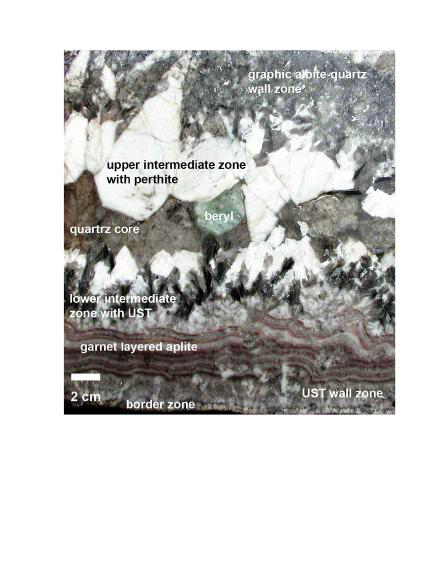

In [25]:
pages = convert_from_path('stock_mage_beryl.pdf', 51)

for page in pages:
    oo=page.save('out.jpg', 'JPEG')
    j=Image.open('out.jpg')
j

<center><b> CITATIONS </b><center>
    
`-----------------------------------------------------------------------------------------`
    
# ◔̯◔

<https://mrdata.usgs.gov/mrds/> (Dataset)

<https://catalogue.data.gov.bc.ca/dataset/rock-properties-database> (Main dataset extra resources)

<http://www.galleries.com/Minerals_By_Name>    

<https://www.minerals.net/MineralVarieties.aspx>

<https://stackoverflow.com/questions/1801668/convert-a-python-list-with-strings-all-to-lowercase-or-uppercase>

<https://stackoverflow.com/questions/37528373/how-to-remove-all-text-between-the-outer-parentheses-in-a-string>

<https://www.rexegg.com/regex-cookbook.html>

<https://minerals.usgs.gov/minerals/pubs/mapdata/>

<https://stackoverflow.com/questions/1720421/how-to-concatenate-two-lists-in-python>

<https://www.minerals.net/Varieties-OtherNames/all.aspx> (webscrape for mineral data)

<https://stackoverflow.com/questions/13779526/finding-a-substring-within-a-list-in-python> (substrings)

<https://stackoverflow.com/questions/30565759/get-unique-values-in-list-of-lists-in-python/30565803> (nested list Unique vals)

<https://geoffboeing.com/2015/10/exporting-python-data-geojson/> (create GEOJSON format from dataframe)

<https://stackoverflow.com/questions/40076241/how-to-calculate-counts-and-frequencies-for-pairs-in-list-of-lists>

<https://stackoverflow.com/questions/44734912/filter-out-elements-that-occur-less-times-than-a-minimum-threshold>

<https://www.geeksforgeeks.org/python-find-maximum-value-in-each-sublist/>

<https://stackoverflow.com/questions/7313157/python-create-list-of-tuples-from-lists>

<https://en.wikibooks.org/wiki/LaTeX/Tables#Basic_examples> (LaTex tables)

<https://stackoverflow.com/questions/46380568/how-to-create-a-stacked-bar-graph-from-nested-dictionary-in-python>

<https://bokeh.pydata.org/en/latest/docs/user_guide/categorical.html> (Vbar nested plot)

<https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them>

<https://www.geeksforgeeks.org/python-find-all-triplets-in-a-list-with-given-sum/>

<https://www.youtube.com/watch?v=6Qs3wObeWwc> (Image manipulation with Pillow)
    
https://www.youtube.com/watch?v=2AFGPdNn4FM